In [1]:
import torch
import torchvision
import random
from shapely.geometry import box
from shapely.geometry import Polygon as shapely_poly
import numpy as np
import pickle

In [2]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) #loading the mask_rcnn from pytorch libraries
model.eval() # sets the model into evaluation mode

c:\Users\suraj\anaconda3\envs\park\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\suraj\anaconda3\envs\park\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
] #names of the labels which are included in the COCO dataset on which this model is trained on

In [4]:
def compute_overlaps(parked_car_boxes, car_boxes): # We have written this function to compute the overlaps
    new_car_boxes = []#creating the carboxes array that stores the 4 points of each box 
    for box in car_boxes:
        y1 = box[0]
        x1 = box[1]
        y2 = box[2]
        x2 = box[3]
        p1 = (x1, y1)
        p2 = (x2, y1)
        p3 = (x2, y2)
        p4 = (x1, y2)
        new_car_boxes.append([p1, p2, p3, p4]) #updating the carboxes array with each box specified with all 4 vertices
    overlaps = np.zeros((len(parked_car_boxes), len(new_car_boxes))) #creating a 2D array which contains the overlapped area(IOU) between each carbox and parking spaces
    for i in range(len(parked_car_boxes)):
        for j in range(car_boxes.shape[0]):
            pol1_xy = parked_car_boxes[i]
            pol2_xy = new_car_boxes[j]
            polygon1_shape = shapely_poly(pol1_xy) #converting the set of 4 vertices into a polygon object using shapely_poly
            polygon2_shape = shapely_poly(pol2_xy) 

            #calculating the IOU and storing them in 2D array

            polygon_intersection = polygon1_shape.intersection(polygon2_shape).area 
            polygon_union = polygon1_shape.union(polygon2_shape).area
            # IOU = polygon_intersection
            IOU = polygon_intersection / polygon_union
            overlaps[i][j] = IOU
    return overlaps


In [5]:
from PIL import Image
from torchvision import transforms as T #transforms is a pytorch library which contains  some functions for normalizing etc that can be applied on numpy arrays or pytorch tensors
import numpy as np

In [6]:
def get_prediction(img_path, threshold=0.5):
  img = Image.open(img_path) # This is for local images
  transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  #We used T.compose so that we can apply multiple transformations at once, here it is not required actually but its a good practice to do
  img = transform(img)
  pred = model([img]) 
  # Now we need to extract the bounding boxes 
  pred_score = list(pred[0]['scores'].detach().cpu().numpy()) #I am taking the scores of predictions and applying .detach().cpu().numpy() inorder to convert into a numpy array
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())] #taking the prediction classes
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())] #taking the boxes from predicted boxes
  pred_boxes = pred_boxes[:pred_t+1] #We previously stored the indices of predictions which have confidence score greater than a threshold, here we are filtering them out
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high res images

In [8]:
import cv2

In [9]:
def instance_segmentation(img_path, threshold=0.5, rect_th=5,
                          text_size=0.4, text_th=3):
  car_boxes = []
  boxes, pred_cls = get_prediction(img_path, threshold=threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  for i in range(len(boxes)):
    pt1 = tuple(int(x) for x in boxes[i][0])#extracting the two diagonal points of the car box so that we will be able to draw a box around that object using cv2
    pt2 = tuple(int(x) for x in boxes[i][1])
    if(pred_cls[i]=='car'):
      car_boxes.append([pt1[0], pt1[1], pt2[0], pt2[1]])
      cv2.rectangle(img, pt1, pt2, color=(255, 255, ), thickness=rect_th)
  return img, car_boxes

In [10]:
img, car_boxes = instance_segmentation('D:\Work\Park\ParkingSpaceDetection\scene1.png', rect_th=1, text_th=1)

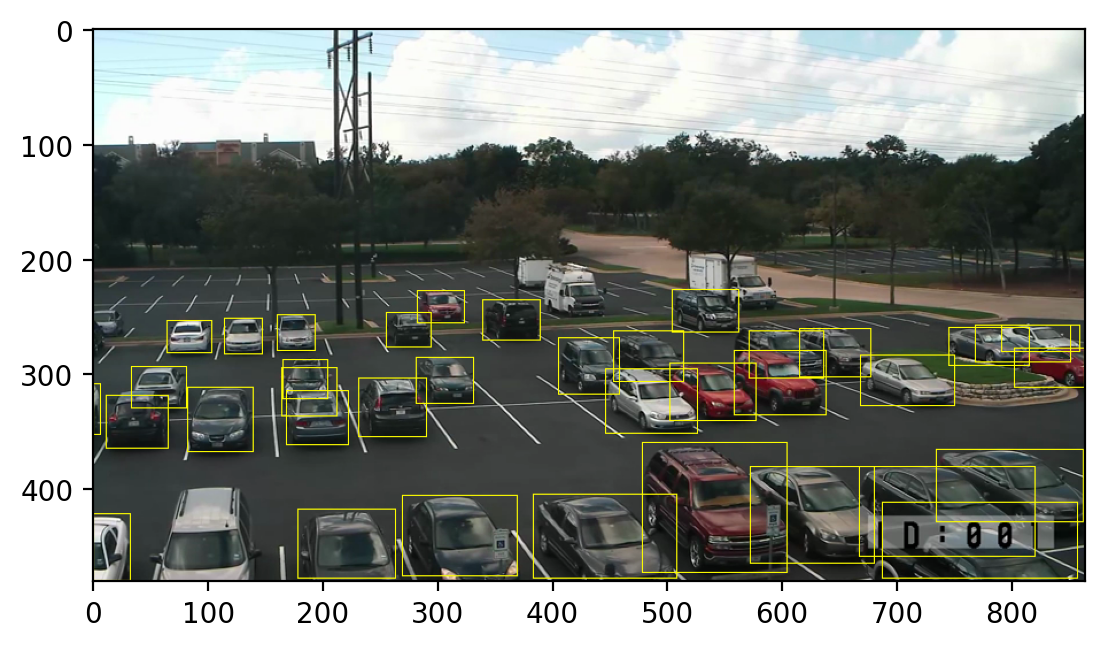

In [11]:
plt.imshow(img)

In [14]:
alpha = 0.6
regions_path = "D:/Work/Park/ParkingSpaceDetection/regions.p"
with open(regions_path, 'rb') as f:
    parked_car_boxes = pickle.load(f)

overlap_areas = compute_overlaps(parked_car_boxes, np.array(car_boxes))
count =0


for parking_area, overlap_area in zip(parked_car_boxes, overlap_areas):
    # max_IoU_overlap = np.max(overlap_area)/parking_area
    max_IoU_overlap = np.max(overlap_area)
    if max_IoU_overlap > 0.15:
        count = count+1
        cv2.fillPoly(img, [np.array(parking_area)], (255, 0, 0))
        free_space = True
    else:
        cv2.fillPoly(img, [np.array(parking_area)], (0, 255, 0))
# cv2.addWeighted(img, alpha, img, 1 - alpha, 0, img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

filename = 'result.jpg'
cv2.imwrite(filename, img)
print(count, " Parking spaces are occupied out of ", len(parked_car_boxes))

1  Parking spaces are occupied out of  4


In [ ]:
from IPython.display import clear_output
import base64
from IPython.display import Image as Ig
import time

In [ ]:
def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Ig(data=encoded.decode('ascii'))

In [ ]:
alpha = 0.6
VIDEO_SOURCE = "D:/Work/Park/ParkingSpaceDetection/video1.mp4"
video_capture = cv2.VideoCapture(VIDEO_SOURCE)
cnt=0

video_FourCC    = cv2.VideoWriter_fourcc('M','J','P','G')
video_fps       = video_capture.get(cv2.CAP_PROP_FPS)
video_size      = (int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
                    int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
out = cv2.VideoWriter("out.avi", video_FourCC, video_fps, video_size)

frame_interval = 5000 # Interval between frames in milliseconds

while video_capture.isOpened():
    # Extract the current position of the video in milliseconds
    current_pos = video_capture.get(cv2.CAP_PROP_POS_MSEC)
    
    # Extract the next frame at the frame interval
    next_pos = current_pos + frame_interval
    video_capture.set(cv2.CAP_PROP_POS_MSEC, next_pos)
    success, frame = video_capture.read()
    success, frame = video_capture.read()
    overlay = frame.copy()
    if not success:
        break

    rgb_image = frame[:, :, ::-1]
    # results = model.detect([rgb_image], verbose=0)
    # car_boxes = get_car_boxes(results[0]['rois'], results[0]['class_ids'])
    filename = 'temp_frame.jpg'
    cv2.imwrite(filename, rgb_image)
    img, car_boxes = instance_segmentation('temp_frame.jpg', rect_th=1, text_th=1)
    
    overlaps = compute_overlaps(parked_car_boxes, np.array(car_boxes))

    for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):
        max_IoU_overlap = np.max(overlap_areas)
        if max_IoU_overlap > 0.108:
            cv2.fillPoly(overlay, [np.array(parking_area)], (0, 100, 0))
            free_space = True
        else:
            cv2.fillPoly(overlay, [np.array(parking_area)], (255, 0, 0))

    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)
    for i in range(20):
        out.write(frame)
    # filename = 'temp_frame1.jpg'
    # cv2.imwrite(filename, frame)
    # cv2.imshow('Video', frame)
    clear_output(wait=True)
    img = arrayShow(frame)
    # display(img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
out.release()
cv2.destroyAllWindows()